In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.spatial import distance
from sklearn.base import TransformerMixin
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, X_test, y, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('dataset.soa.explain.pickle', 'rb') as f:
    background_data, X_explain = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_log_odds_a, shap_log_odds_b, shap_log_odds_a_vs_b, is_finite, is_outlier, is_normal, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


Now we define the functions to be explained:

In [4]:
log_proba_to_log_odds = lambda log_proba: log_proba[:, 1] - log_proba[:, 0]
predict_log_odds_a = lambda X: log_proba_to_log_odds(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: log_proba_to_log_odds(clf_b.predict_log_proba(X))

And now we calculate SHAP values for each function:

In [5]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    return shap_values

In [6]:
%%time
shap_log_odds_a = explain(predict_log_odds_a, background_data)
shap_log_odds_b = explain(predict_log_odds_b, background_data)

shap_log_odds_a_vs_b = shap_log_odds_b - shap_log_odds_a
shap_log_odds_a_vs_b.data = shap_log_odds_a.data
shap_log_odds_a_vs_b.display_data = shap_log_odds_a.display_data

is_finite = np.all(np.isfinite(shap_log_odds_a.values), axis=1) & np.all(np.isfinite(shap_log_odds_b.values), axis=1)
is_outlier = np.any(shap_log_odds_a.abs.values > 12, axis=1) | np.any(shap_log_odds_b.abs.values > 12, axis=1)
is_normal = is_finite & ~is_outlier
feature_order = np.flip(shap_log_odds_a_vs_b[is_normal].abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_log_odds_a, shap_log_odds_b, shap_log_odds_a_vs_b, is_finite, is_outlier, is_normal, feature_order), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.52 s, sys: 112 ms, total: 4.64 s
Wall time: 5.56 s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

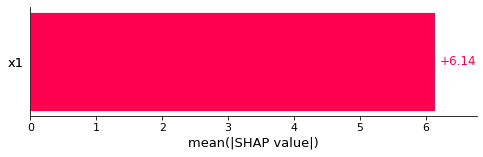

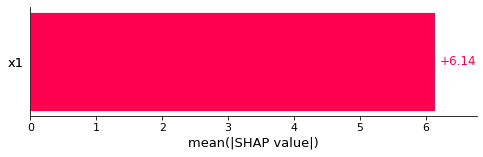

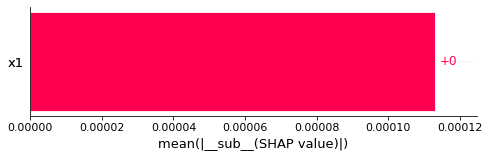

In [7]:
shap.plots.bar(shap_log_odds_a[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_log_odds_b[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_log_odds_a_vs_b[is_normal], order=feature_order, max_display=n_features)

### SHAP Value Distribution

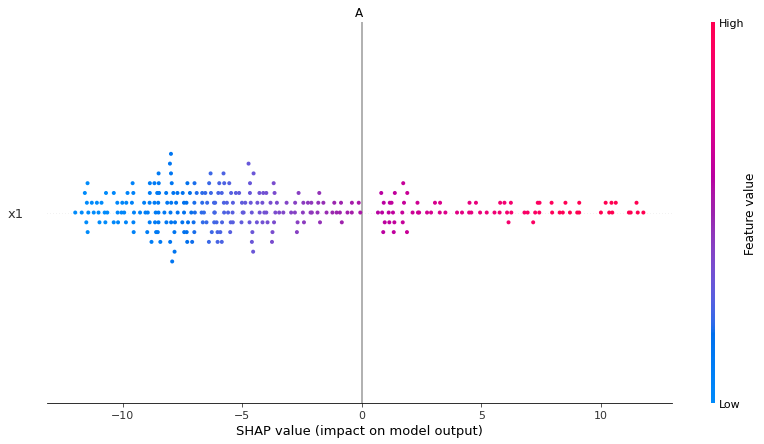

In [8]:
plot.shap_beeswarm(shap_log_odds_a[is_normal], 'A', order=feature_order, max_display=n_features)

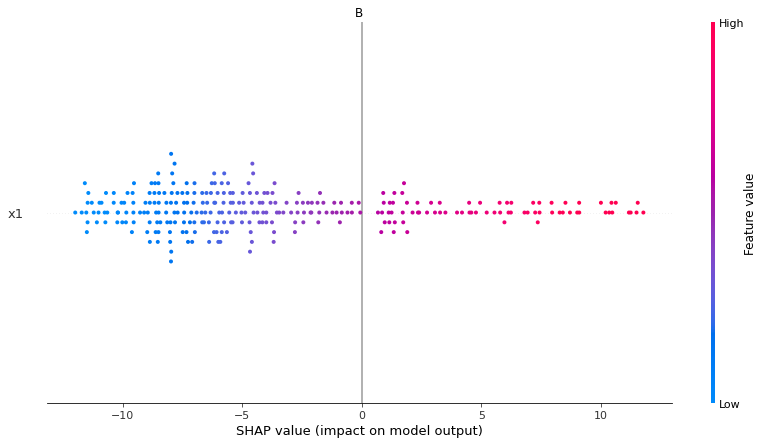

In [9]:
plot.shap_beeswarm(shap_log_odds_b[is_normal], 'B', order=feature_order, max_display=n_features)

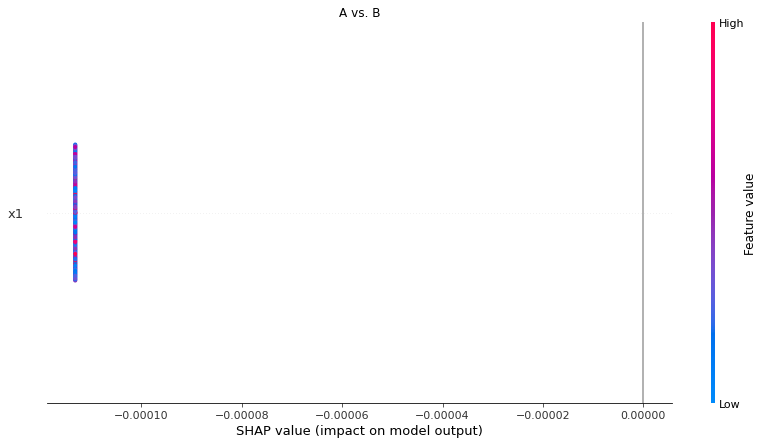

In [10]:
plot.shap_beeswarm(shap_log_odds_a_vs_b[is_normal], 'A vs. B', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

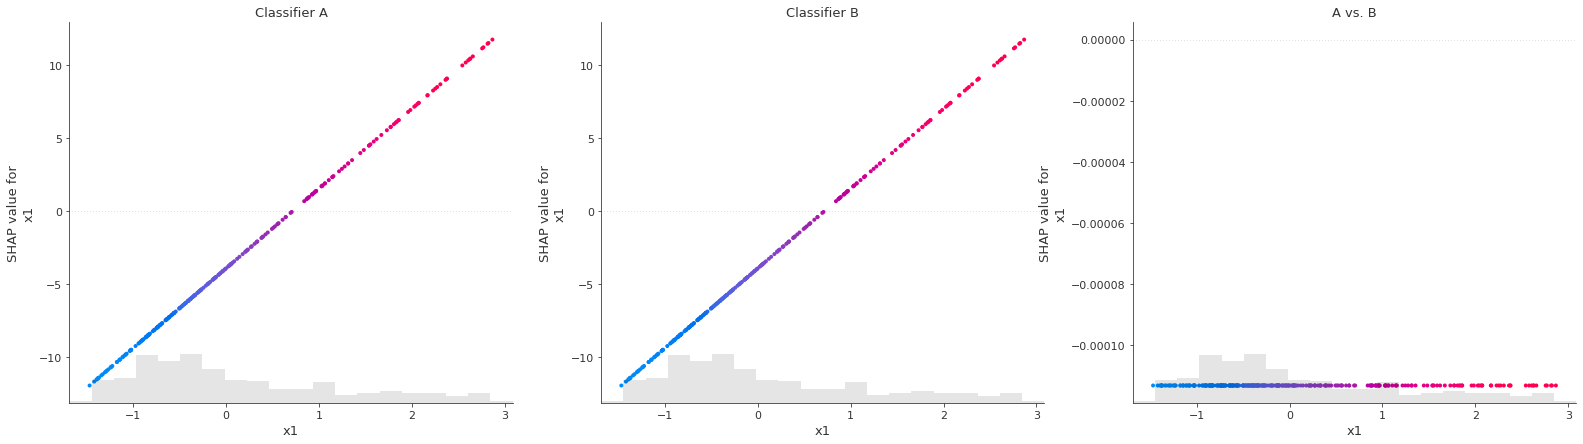

In [30]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_log_odds_a[is_normal], feature, 'Classifier A', ax=ax)
    plot.shap_scatter(shap_log_odds_b[is_normal], feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_log_odds_a_vs_b[is_normal], feature, 'A vs. B', ax=fig.add_subplot(n_rows, n_columns, i+2))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [22]:
order = plot.shap_force(shap_log_odds_a[is_normal], 'A')
plot.shap_force(shap_log_odds_b[is_normal], 'B', ordering=order)
plot.shap_force(shap_log_odds_a_vs_b[is_normal], 'A vs. B', ordering=order);

### Hierarchically Clustered SHAP Values

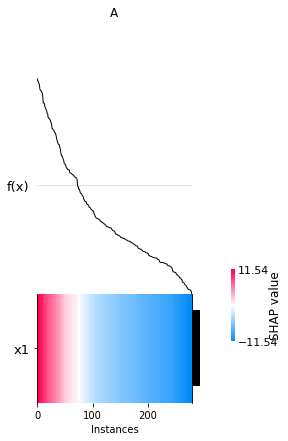

In [23]:
plot.shap_heatmap(shap_log_odds_a[is_normal], 'A', feature_order)

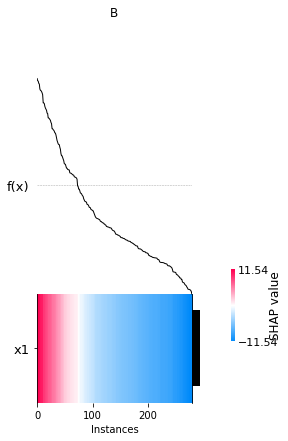

In [24]:
plot.shap_heatmap(shap_log_odds_b[is_normal], 'B', feature_order)

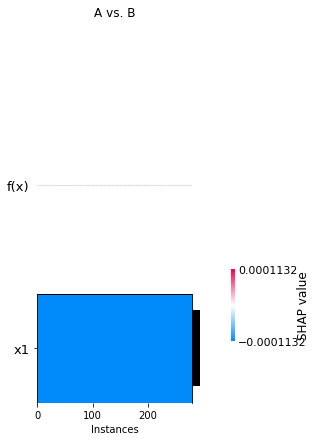

In [25]:
plot.shap_heatmap(shap_log_odds_a_vs_b[is_normal], 'A vs. B', feature_order)

### Unusual instances

#### Outliers in SHAP-values

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [26]:
idx_outliers = np.where(is_outlier & is_finite)[0]

In [27]:
pd.DataFrame(display_data_explain[idx_outliers, :], index=idx_outliers, columns=feature_names)

NameError: name 'display_data_explain' is not defined

In [ ]:
for idx in idx_outliers:
    plot.shap_force(shap_log_odds_a[idx], f'Instance #{idx}')

In [ ]:
for idx in idx_outliers:
    plot.shap_force(shap_log_odds_b[idx], f'Instance #{idx}')

#### Non-finite SHAP-values

~The `NaN` shap values in Workclass and Relationship seem to be connected to the unusually high capital gain~

In [28]:
idx_nonfinite = np.where(~is_finite)[0]

In [29]:
pd.DataFrame(display_data_explain[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

NameError: name 'display_data_explain' is not defined

In [ ]:
pd.DataFrame(shap_log_odds_a[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

In [ ]:
pd.DataFrame(shap_log_odds_b[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)